### Block with Tees

In [1]:
from microfluidics_ipkiss3.technology import * #comment when running main script, uncomment to debug geometry
from ipkiss3 import all as i3
import microfluidics_ipkiss3.all as microfluidics

import sys
sys.path.append("..")   #adding higher directory

from block import Block
from tee import TeeSimple

# PCell containing two tees
class BlockWithTees(i3.PCell):
    """Parametric cell with trap and tee defined by the user
    """
    _name_prefix = "BLOCK_W_TEES"

    # 1.
    # The trap and tee are defined as ChildCellProperties. This is a special property
    # that for hierarchical PCells. In each view of the PCell of a certain type (e.g. Layout)
    # the corresponding viewtype (e.g. Layout) of the ChildCell will automatically available.

    block = i3.ChildCellProperty(default = Block())
    tee = i3.ChildCellProperty(default = TeeSimple())
    TECH = i3.get_technology()

    # Layout view
    class Layout(i3.LayoutView):

        def _generate_instances(self, insts):
            insts += i3.place_insts(
                insts={
                    'inlet': self.tee,
                    'block': self.block,
                    'outlet': self.tee
                },
                specs=[
                    i3.Place('block', (0, 0)),
                    i3.Join([
                        ('inlet:out1', 'block:in1'),
                        ('outlet:out1', 'block:out1')
                    ]),
                    i3.FlipH('outlet'),
                    ]
                )
            return insts

        def _generate_ports(self, ports):
            return i3.expose_ports(self.instances,
                                   {'inlet:in1': 'in1',
                                    'inlet:in2': 'in2',
                                    'outlet:in1': 'out1',
                                    'outlet:in2': 'out2'
                                    })


In [2]:

    #STL and OF sim
    
if __name__ == "__main__":
    print "This is not the main file. Run 'execute.py' in the same folder"

    block = Block()
    block.Layout(block_length= 300.0)
    #t.visualize_2d()
    tee = TeeSimple()
    tee.Layout(tee_length=100)
    #a.visualize_2d()

    myBlock_withTees= BlockWithTees(
                            block = block,
                            tee = tee)
    layout = myBlock_withTees.Layout()

    #Writing to GDSII and visualization
    #layout.write_gdsii("myTrap_withTees.gds")
    layout.visualize(annotate = True)


This is not the main file. Run 'execute.py' in the same folder


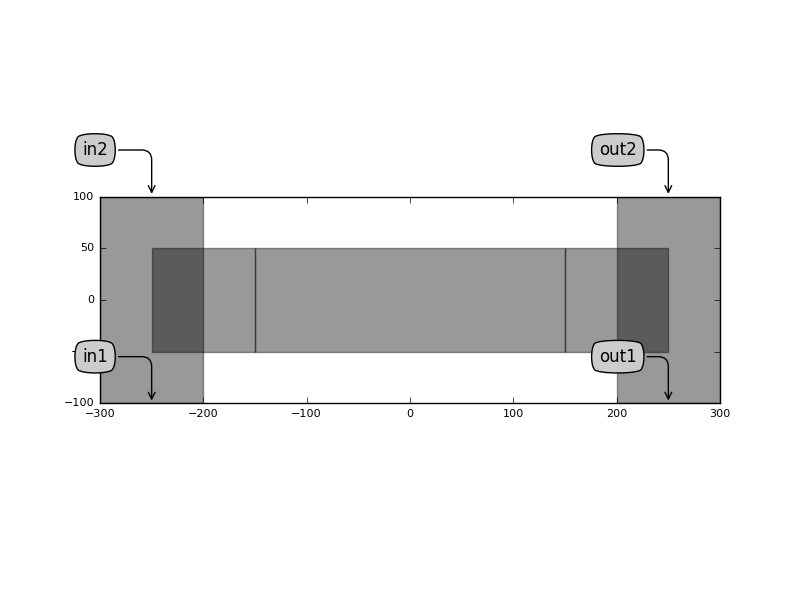

In [3]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/block_with_tees.png", width = 600, height = 300)


STL Generation through OpenFOAM engine

In [4]:

    #STL and OF sim
    
if __name__ == "__main__":
    print "This is not the main file. Run 'execute.py' in the same folder"

    #generating STL and OF sim

    from microfluidics_ipkiss3.pysimul.openfoam.openfoam_engine import *
    from microfluidics_ipkiss3.pysimul.openfoam.turbulence_model import *
    from microfluidics_ipkiss3.pysimul.openfoam.transport_model import *

    # Control how the mesh is generated

    snap_control = SnapControl(num_smooth_patch=1)
    add_layer_control = AddLayerControl(final_layer_thickness=10, min_thickness=1, num_grow=10)
    mesh_quality_control = MeshQualityControl(max_non_orthogonal=90)
    mesh_control = MeshControl(mesh_size=20, feature_refinement_level=2,
                               surface_refinement_level=(1, 2),
                               refinement_regions=[(1, 2)],
                               snap_mesh=True, snap_control=snap_control,
                               add_layer=True, add_layer_control=add_layer_control,
                               mesh_quality_control=mesh_quality_control)

    # Transport and turbulence models

    transport_model = NewtonianModel(kinematic_viscosity=0.00345 / 1050)
    turbulence_model = LaminarModel()

    # Create a list of properties required by simpleFoam solver including the transport property
    # and a list of properties returned by turbulenace model

    properties = [transport_model.get_model_property()] + turbulence_model.get_model_properties()

    # Initialise the engine with simpleFoam solver

    engine = OpenFoamEngine(mesh_control=mesh_control, solver='simpleFoam',
                            properties=properties)

    from microfluidics_ipkiss3.pysimul.runtime.basic import *

    params = dict()
    params["engine"] = engine
    params["inlets"] = [FixedVelocityInlet(in_port_number=2, velocity=(0.0, 50.0e-3, 0)),
                        FixedVelocityInlet(in_port_number=0, velocity=(0.0, -50e-3, 0.0)),
                        #FixedVelocityInlet(in_port_number=2, velocity=(0.0, 30e-3, 0.0))
                         ]

    window_si = SizeInfo(west=-260, east=260, south=-360, north=360)
    #params["window_size_info"] = window_si

    # 2D simulation
    params["dimensions"] = 3

    # Create and run simulation

    from ipkiss.plugins.simulation import *

    simul = layout.create_simulation(simul_params=params)

    # Start running simulation

    simul.procedure.run(case_name='one_block_with_tees', use_existing_mesh=False, interactive=True)


This is not the main file. Run 'execute.py' in the same folder


Finish generating mesh.

Final mesh is in one_block_with_tees/constant/polyMesh



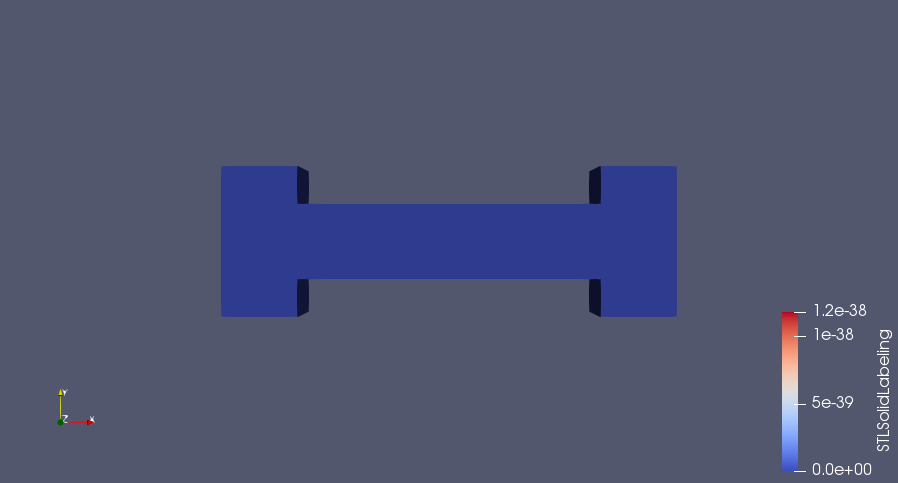

In [1]:
from IPython.display import Image# Load image from local storage
Image(filename = "files/block_with_tees_stl.png", width = 600, height = 300)

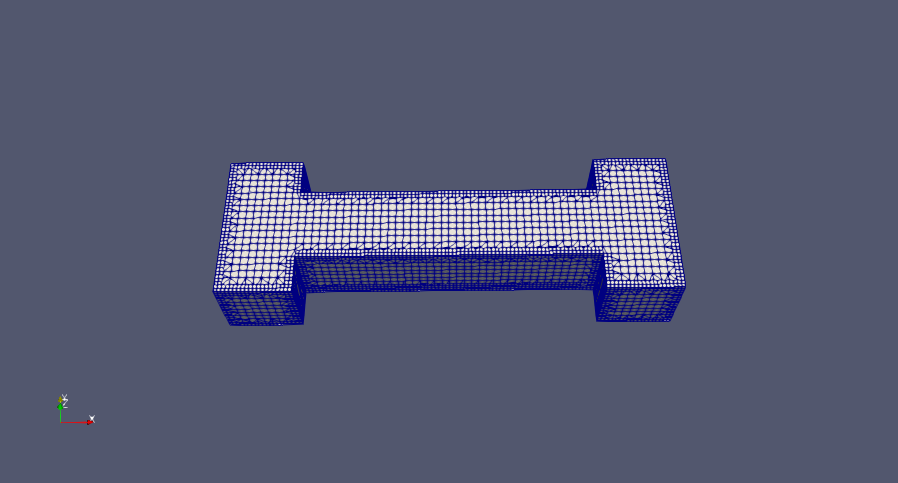

In [3]:
from IPython.display import Image# Load image from local storage
Image(filename = "files/block_with_tees_mesh.png", width = 600, height = 300)

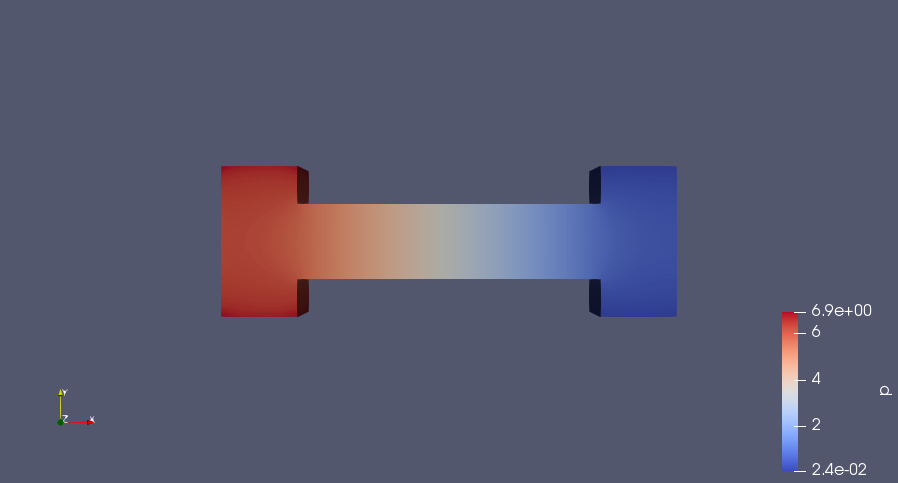

In [6]:
from IPython.display import Image# Load image from local storage
Image(filename = "files/block_with_tees_pressure.png", width = 600, height = 300)

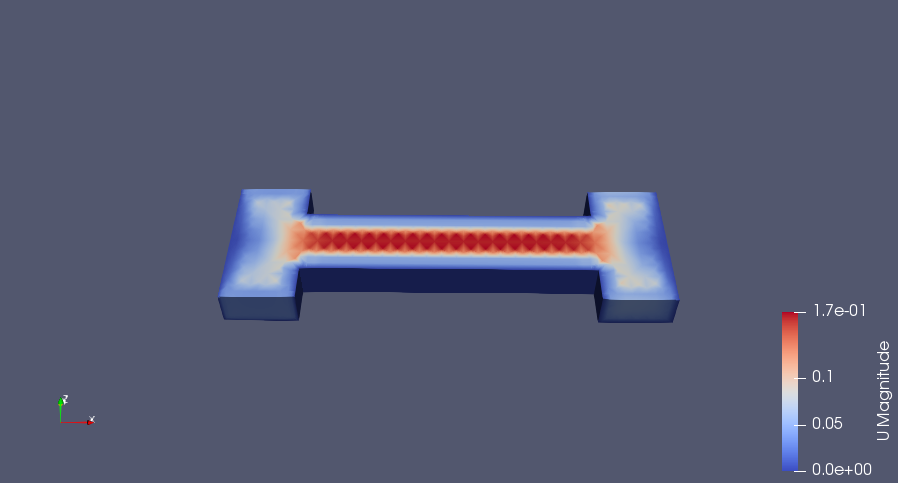

In [7]:
from IPython.display import Image# Load image from local storage
Image(filename = "files/block_with_tees_vel.png", width = 600, height = 300)

Mesh size 20